In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('data/summary.csv')
dahlia_accepted = pd.read_csv('data/dahlia-points.csv')

# Cleanup data
df.bench = df.apply(lambda row: row.bench.replace('gemm-dse:gemm-', ''), axis=1)
dahlia_accepted = dahlia_accepted.apply(lambda row: row.bench.replace('dahlia-gemm-', ''), axis=1)

for key in df.columns:
    if key != 'bench':
        df[key] = pd.to_numeric(df[key], errors='coerce')

# Configurations in bad states
missing_confs = df[df.isnull().any(axis=1)]
df = df[df.notnull().all(axis=1)].reset_index()

In [4]:
# Make sure estimated latencies are consistent
for idx in range(len(df)):
    assert df.est_min_lat[idx] == df.est_max_lat[idx], idx

In [5]:
dahlia_points = df[df["bench"].isin(dahlia_accepted.to_numpy())]

In [6]:
# Set of scatter plots to draw
resources = [ 'est_' + key for key in [ 'ff', 'dsp', 'bram', 'lut' ]]
lat_plots = [ ('est_max_lat', key) for key in resources ]
lut_plots = [ ('est_lut', key) for key in resources]

In [7]:
# Calculate pareto points
# From: https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python

# If difference between two points is less that LAT_BOUND, then
# don't consider it as "better latency".
LAT_BOUND = 10

def find_pareto(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        (before, after) = costs[:i], costs[i+1:]
        # All points such that there is no point which has at least one objective minimized better and other objectives at least equal.
        is_efficient[i] = np.all(np.logical_not(np.logical_and(np.all(before <= c, axis=1), np.any(before < c, axis=1)))) and \
                          np.all(np.logical_not(np.logical_and(np.all(after <= c, axis=1), np.any(after < c, axis=1))))
    return is_efficient

opts = find_pareto(df[['est_compute_lat'] + resources].to_numpy())
opt_idxs = np.where(opts == True)
pareto_points = df.iloc[opt_idxs]

# Number of true pareto trade off points
print("Pareto points: ", len(pareto_points[['est_compute_lat'] + resources].drop_duplicates()))

Pareto points:  56


In [8]:
pareto_points.sort_values(by=['est_compute_lat'])[:10]

,index,bench,bank11,bank12,bank21,bank22,unroll1,unroll2,unroll3,target_clk,estimate_clk,est_min_lat,est_max_lat,est_bram,est_dsp,est_ff,est_lut,est_read_lat,est_compute_lat,est_write_lat
24832,24837,3-3-3-3-2-2-3,4,4,4,4,4,4,6,4.0,2.92,81947.0,81947.0,98.0,1024.0,72701.0,25738.0,32776.0,32775.0,16390.0
22506,22511,3-3-3-3-2-3-1,4,4,4,4,4,6,2,4.0,2.92,81947.0,81947.0,98.0,1024.0,72701.0,25738.0,32776.0,32775.0,16390.0
28087,28094,3-3-3-3-2-3-4,4,4,4,4,4,6,8,4.0,2.92,81947.0,81947.0,98.0,1024.0,72701.0,25738.0,32776.0,32775.0,16390.0
9185,9188,3-3-3-3-2-3-2,4,4,4,4,4,6,4,4.0,2.92,81947.0,81947.0,98.0,1024.0,72701.0,25738.0,32776.0,32775.0,16390.0
10820,10823,3-3-3-3-2-1-3,4,4,4,4,4,2,6,4.0,2.92,81947.0,81947.0,98.0,1024.0,72701.0,25738.0,32776.0,32775.0,16390.0
8395,8397,3-3-3-3-2-1-4,4,4,4,4,4,2,8,4.0,2.92,81947.0,81947.0,98.0,1024.0,72701.0,25738.0,32776.0,32775.0,16390.0
24234,24239,3-3-3-3-2-4-1,4,4,4,4,4,8,2,4.0,2.92,81947.0,81947.0,98.0,1024.0,72701.0,25738.0,32776.0,32775.0,16390.0
10936,10939,3-3-3-3-2-4-2,4,4,4,4,4,8,4,4.0,2.92,81947.0,81947.0,98.0,1024.0,72701.0,25738.0,32776.0,32775.0,16390.0
6215,6215,3-3-3-3-2-1-1,4,4,4,4,4,2,2,4.0,2.92,81947.0,81947.0,98.0,1024.0,72701.0,25738.0,32776.0,32775.0,16390.0
11818,11821,3-3-3-3-2-2-2,4,4,4,4,4,4,4,4.0,2.92,81947.0,81947.0,98.0,1024.0,72701.0,25738.0,32776.0,32775.0,16390.0


In [9]:
# Dahlia points not in pareto frontier
non_pareto_dahlia = set(dahlia_points.bench).difference(set(pareto_points.bench))
pareto_dahlia = set(dahlia_points.bench).intersection(set(pareto_points.bench))

non_pareto_dahlia_points = df[df.bench.isin(non_pareto_dahlia)]
pareto_dahlia_points = df[df.bench.isin(pareto_dahlia)]

print("Dahlia non pareto configurations: ", len(non_pareto_dahlia_points[['est_compute_lat'] + resources].drop_duplicates()))
print("Pareto pareto configurations: ", len(pareto_dahlia_points[['est_compute_lat'] + resources].drop_duplicates()))

Dahlia non pareto configurations:  814
Pareto pareto configurations:  33


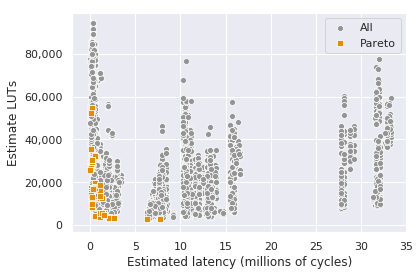

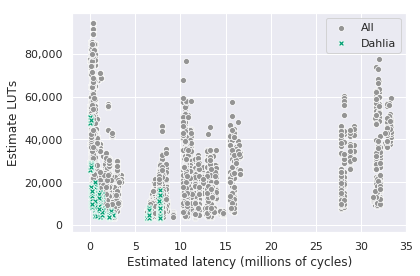

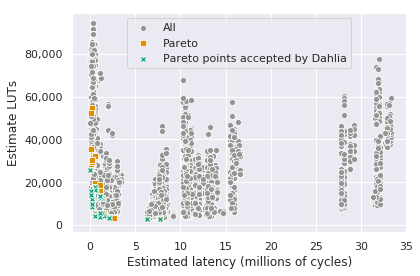

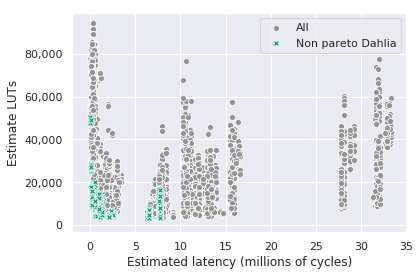

In [13]:
sns.set()
import matplotlib

pal = sns.color_palette('colorblind', 8)

# Settings
groups = [
    {'label': 'All', 'data': df, 'color': pal[-1], 'marker': 'o', 'alpha': 0.05},
    {'label': 'Pareto', 'data': pareto_points, 'color': pal[1], 'marker': 's', 'alpha': 0.5},
    {'label': 'Dahlia', 'data': dahlia_points, 'color': pal[2], 'marker': 'X', 'alpha': 0.2},
    {'label': 'Non pareto Dahlia', 'data': non_pareto_dahlia_points, 'color': pal[2], 'marker': 'X', 'alpha': 0.2},
    {'label': 'Pareto points accepted by Dahlia', 'data': pareto_dahlia_points, 'color': pal[2], 'marker': 'X', 'alpha': 0.2}
]

to_plot = [
    {'prefix': 'only-pareto', 'groups': [0, 1]},
    {'prefix': 'only-dahlia', 'groups': [0, 2]},
    {'prefix': 'dahlia-pareto', 'groups': [0, 1, 4]},
    {'prefix': 'dahlia-non-pareto', 'groups': [0,3]}
]

for plot_info in to_plot:
    fig = plt.figure()
    ax = fig.gca()
    for g in plot_info['groups']:
        group = groups[g]
        sns.scatterplot(x='est_compute_lat', y='est_lut', data=group['data'], color=group['color'], marker=group['marker'], label=group['label'])
    
    ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x / 10 ** 6), ',')))
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_xlabel('Estimated latency (millions of cycles)')
    ax.set_ylabel('Estimate LUTs')
    fig.tight_layout()
    fig.savefig("gemm-blocked-dse-{}.pdf".format(plot_info['prefix']))
